<a href="https://www.kaggle.com/code/mariamelghandoor/paper-2?scriptVersionId=238413351" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Deep learning based detection and analysis of COVID-19 on chest X-ray images
 [**Paper Link**](https://link.springer.com/article/10.1007/s10489-020-01902-1)

# Imports and Installs

In [1]:
!pip install lime -q

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
import tensorflow as tf


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries


from shutil import copyfile
import pandas as pd
import numpy as np 
import cv2
import os

# Helper Functions

In [3]:
def preprocess_image(image_path):
    try:
        img = imread(image_path, as_gray=False)
        img = resize(img, (256, 256), anti_aliasing=True)
        if len(img.shape) == 2:
            img_rgb = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img_rgb = np.repeat(img, 3, axis=-1)
        else:
            img_rgb = img
        img_normalized = img_rgb / 255.0 if img_rgb.max() > 1 else img_rgb
        if len(img.shape) == 2 or (len(img.shape) == 3 and np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2])):
            img_viz = img if len(img.shape) == 2 else img[:, :, 0]
        else:
            img_viz = img_rgb
        return img_normalized, img_viz
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None


In [4]:
def split_train_val(data_dir, output_dir, train_ratio=0.95):  # 70/(70+10) = 0.875
    classes = ['covid19', 'normal', 'pneumonia']
    os.makedirs(output_dir, exist_ok=True)
    
    for split in ['train', 'val']:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)
    
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        train_imgs, val_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
        
        for img in train_imgs:
            copyfile(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
        for img in val_imgs:
            copyfile(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))
    
    print("Train-validation split completed.")

# plotting functions for train test tracing

In [5]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_multiclass_roc_pr(y_true, y_probs, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    plt.figure(figsize=(14, 6))

    # ROC Curves
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('Multiclass ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR Curves
    plt.subplot(1, 2, 2)
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f"{class_names[i]} (AP = {ap:.2f})")
    plt.title('Multiclass Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
def plot_confusion_matrix(model, test_generator):
    Y_true = test_generator.classes
    Y_pred_probs = model.predict(test_generator)
    Y_pred = np.argmax(Y_pred_probs, axis=1)

    cm = confusion_matrix(Y_true, Y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
def predict_fn(images):
    images = np.array(images)
    if images.shape[-1] != 3:
        images = np.repeat(images, 3, axis=-1)
    images = np.clip(images, 0, 1)
    return model.predict(images, verbose=0)

# XAI functions for imgs

In [9]:
def explain_with_lime(model, image_paths_with_labels):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=2, max_dist=100, ratio=0.2)

    for image_path, class_name in image_paths_with_labels:
        img_normalized, img_viz = preprocess_image(image_path)
        if img_normalized is None:
            print(f"Skipping {image_path} due to preprocessing error.")
            continue

        try:
            explanation = explainer.explain_instance(
                img_normalized,
                predict_fn,
                top_labels=3,
                hide_color=None,
                num_samples=500,
                segmentation_fn=segmenter
            )
        except Exception as e:
            print(f"Error explaining image {image_path}: {e}")
            continue

        pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)
        predicted_class = class_labels[np.argmax(pred)]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.imshow(img_viz, cmap='gray' if len(img_viz.shape) == 2 else None)
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        base_image = img_viz
        if len(base_image.shape) == 2:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = 1
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = 'gray'
        else:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = [1, 0, 0]
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = None

        highlighted_image = mark_boundaries(highlighted_image, mask, color=(1, 0, 0), mode='thick')
        ax2.imshow(highlighted_image, cmap=cmap)
        ax2.set_title('LIME Highlights')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image: {image_path}")
        print(f"Predicted probabilities: {dict(zip(class_labels, pred[0]))}\n")

In [10]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    try:
        conv_layer = model.get_layer(last_conv_layer_name)
    except ValueError:
        print("Available layers:")
        for layer in model.layers:
            print(layer.name)
        raise ValueError(f"Layer '{last_conv_layer_name}' not found in the model. Check layer names above.")

    grad_model = Model(
        inputs=[model.inputs],
        outputs=[conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU and normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap)
    if max_val > 0:
        heatmap = heatmap / max_val
    else:
        print("Warning: Heatmap is all zeros, returning empty heatmap")
        heatmap = np.zeros_like(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    if original_img.max() <= 1.0:
        original_img = original_img * 255
    original_img = np.uint8(original_img)
    
    superimposed_img = heatmap * alpha + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def apply_grad_cam(model, image_path, class_label, class_labels, last_conv_layer_name='conv2d_19', save_dir='.'):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    sample_img = img.astype(np.float32) / 255.0
    sample_img_array = np.expand_dims(sample_img, axis=0)

    print(f"\nProcessing image: {image_path}")
    print("Sample image shape:", sample_img.shape)
    print("Sample image min/max:", sample_img.min(), sample_img.max())
    if sample_img_array.shape != (1, 256, 256, 3):
        raise ValueError(f"Sample image shape {sample_img_array.shape} does not match expected shape (1, 256, 256, 3)")

    predictions = model.predict(sample_img_array, verbose=1)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    print("Predicted class:", predicted_class)
    print("Predictions:", predictions[0])

    heatmap = get_gradcam_heatmap(model, sample_img_array, last_conv_layer_name, pred_index=predicted_class_idx)
    print("Heatmap shape:", heatmap.shape)
    print("Heatmap min/max:", heatmap.min(), heatmap.max())

    superimposed_img = overlay_heatmap(heatmap, sample_img)


    plt.subplot(1, 2, 1)
    plt.title(f'Original Image\n(True: {class_label})')
    plt.imshow(sample_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Grad-CAM\n(Pred: {predicted_class})')
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.tight_layout()

    save_filename = f'grad_cam_{class_label}.png'
    save_path = os.path.join(save_dir, save_filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot saved to: {os.path.abspath(save_path)}")

    plt.show()

    plt.close()


In [11]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    diff = img - baseline
    
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    multipliers = grads
    contributions = diff * multipliers  
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10) 
    return heatmap, pred_index

def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

In [12]:
def permutation_importance(image, model, class_index, model_name, raw_image, patch_size=32):
    image = np.expand_dims(image, axis=0)
    correct_prob = model.predict(image, verbose=0)[0, class_index]  

    importance_map = np.zeros((256 // patch_size, 256 // patch_size))

    for i in range(0, 256, patch_size):
        for j in range(0, 256, patch_size):
            permuted = image.copy()
            
            # Permute the entire patch, not just 1 pixel
            for c in range(3):
                permuted[0, i:i+patch_size, j:j+patch_size, c] = np.random.rand(patch_size, patch_size)
            
            pred_prob = model.predict(permuted, verbose=0)[0, class_index]
            importance = correct_prob - pred_prob  # how much probability dropped
            importance_map[i // patch_size, j // patch_size] = importance

    # Upsample map to image size for visualization
    heatmap = cv2.resize(importance_map, (256, 256))

    plt.figure(figsize=(6, 6))
    plt.imshow(raw_image)
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.title(f"{model_name}")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


# Load data and apply Augmentation

In [14]:
train_dir = '/kaggle/input/feature-selelcted-dataset/train'
output_dir = '/kaggle/working/chest-xray-covid19-pneumonia/split'
split_train_val(train_dir, output_dir)
test_dir = '/kaggle/input/feature-selelcted-dataset/test'

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    classes=['covid19', 'normal', 'pneumonia']
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    classes=['covid19', 'normal', 'pneumonia']
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    classes=['covid19', 'normal', 'pneumonia'],
    shuffle=False
)

Train-validation split completed.
Found 1142 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


# Model

In [15]:
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    last_conv_layer = base_model.get_layer('block14_sepconv2_act')
    x = last_conv_layer.output
    x = Flatten()(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(3)(x)

    outputs = tf.keras.layers.Softmax()(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    base_model.trainable = False

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [16]:
model = create_xception_model()

model.summary()

I0000 00:00:1746636997.699120      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746636997.699804      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 127, 127, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 127, 127, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 125, 125, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 125, 125, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 125, 125, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 125, 125, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 125, 125, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 125, 125, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 63, 63, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 54,416,939 (207.58 MB)

 Trainable params: 33,555,459 (128.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# Train and Test

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746637010.202255     121 service.cc:148] XLA service 0x7fe6a4003450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746637010.203952     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746637010.203974     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746637011.192590     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/72 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4219 - loss: 142.9773 

I0000 00:00:1746637018.372798     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5679 - loss: 203.7638 - val_accuracy: 0.7302 - val_loss: 35.0931 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 0.7180 - loss: 59.8007 - val_accuracy: 0.6825 - val_loss: 44.7613 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.7356 - loss: 40.1328 - val_accuracy: 0.7460 - val_loss: 37.5132 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.7338 - loss: 27.8746 - val_accuracy: 0.7778 - val_loss: 9.6054 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.7666 - loss: 25.1328 - val_accuracy: 0.6984 - val_loss: 51.3065 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.7744 - loss: 23.9180 - val_accuracy: 0.6984 - val_loss: 14.2845 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.8098 - loss: 1

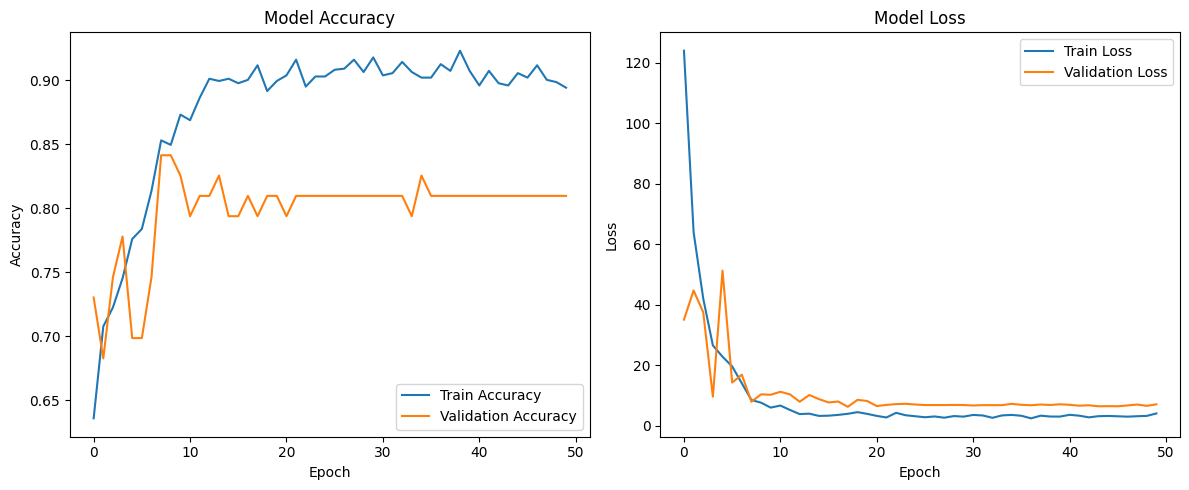

In [18]:
plot_learning_curves(history)

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step


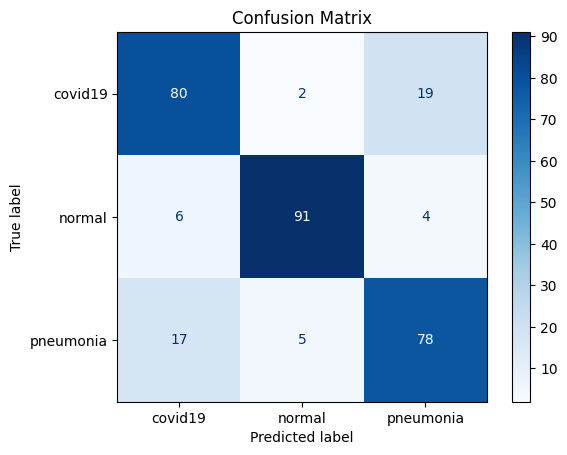

In [19]:
plot_confusion_matrix(model, test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


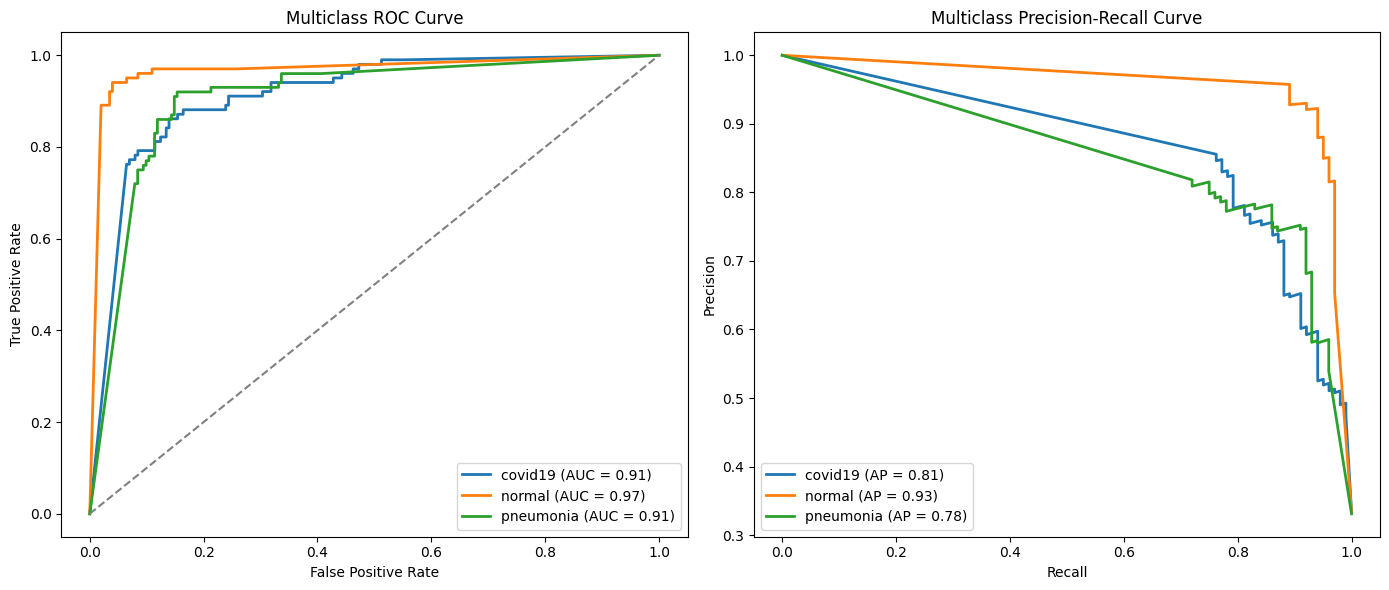

In [20]:
class_labels = ['covid19', 'normal', 'pneumonia']
y_true = []
y_probs = []
y_pred = []

for x_batch, y_batch in test_generator:
    preds = model.predict(x_batch)
    y_probs.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y_batch, axis=1)) 

    if len(y_true) >= test_generator.samples:
        break

y_true = np.array(y_true)
y_probs = np.array(y_probs)

plot_multiclass_roc_pr(y_true, y_probs, class_labels)

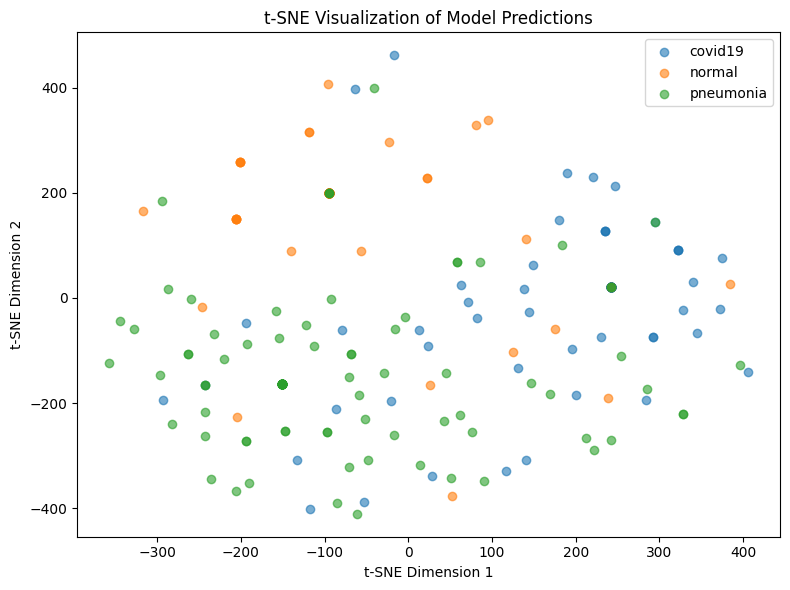

In [21]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(y_probs)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    indices = y_true == i
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=class_names[i], alpha=0.6)

plt.title("t-SNE Visualization of Model Predictions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

y_true_onehot = np.eye(len(test_generator.class_indices))[y_true]
auc = roc_auc_score(y_true_onehot, y_probs, multi_class='ovr')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print(f"AUC (macro): {auc:.4f}")


Precision (macro): 0.8258
Recall (macro): 0.8244
F1-score (macro): 0.8250
AUC (macro): 0.9298


# Explanatory Techniques

### LIME

  0%|          | 0/500 [00:00<?, ?it/s]

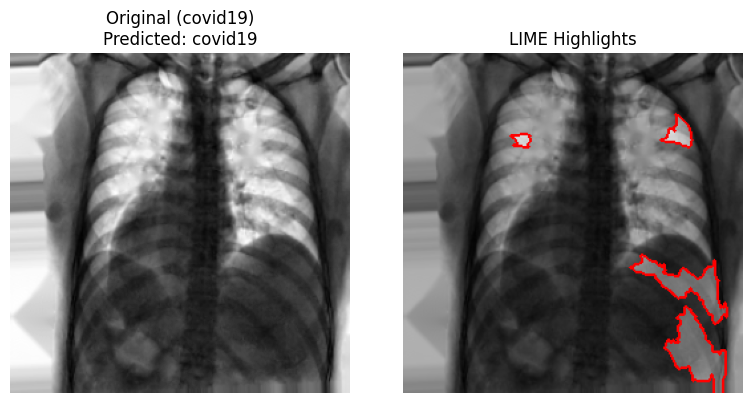

Image: /kaggle/input/feature-selelcted-dataset/test/covid19/image_195.png
Predicted probabilities: {'covid19': 0.99999976, 'normal': 7.728715e-34, 'pneumonia': 1.9842402e-07}



  0%|          | 0/500 [00:00<?, ?it/s]

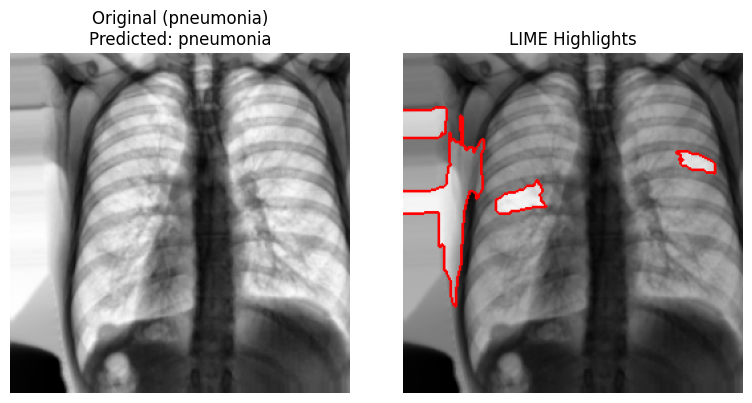

Image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_286.png
Predicted probabilities: {'covid19': 1.7038582e-06, 'normal': 2.3148908e-28, 'pneumonia': 0.99999833}



  0%|          | 0/500 [00:00<?, ?it/s]

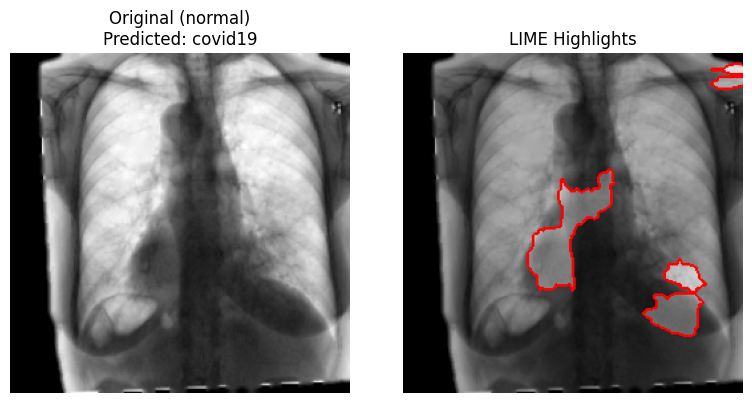

Image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_165.png
Predicted probabilities: {'covid19': 0.9873683, 'normal': 9.928411e-16, 'pneumonia': 0.012631728}



In [25]:
try:
    image_paths = [
        ("/kaggle/input/feature-selelcted-dataset/test/covid19/image_195.png", "covid19"),
        ("/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_286.png","pneumonia"),
        ("/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_165.png","normal")
    ]
    explain_with_lime(model, image_paths)
except Exception as e:
    print(f"Error loading sample images: {e}")

### GRAD-CAM


Processing image: /kaggle/input/feature-selelcted-dataset/test/covid19/image_195.png
Sample image shape: (256, 256, 3)
Sample image min/max: 0.011764706 0.99607843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: covid19
Predictions: [9.9999988e-01 4.8285428e-34 1.4918983e-07]
Heatmap shape: (8, 8)
Heatmap min/max: 0.0 1.0
Plot saved to: /kaggle/working/grad_cam_covid19.png


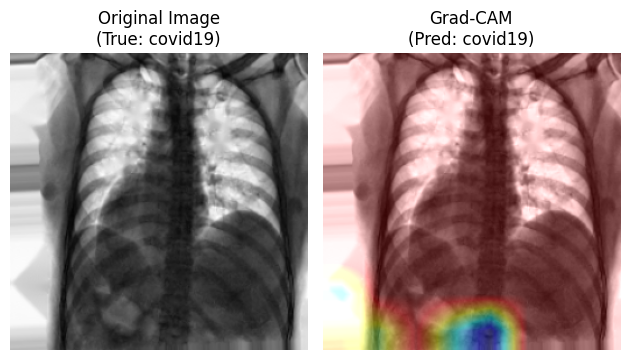


Processing image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_286.png
Sample image shape: (256, 256, 3)
Sample image min/max: 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class: pneumonia
Predictions: [1.6766426e-06 3.3996424e-28 9.9999833e-01]
Heatmap shape: (8, 8)
Heatmap min/max: 0.0044802674 1.0
Plot saved to: /kaggle/working/grad_cam_pneumonia.png


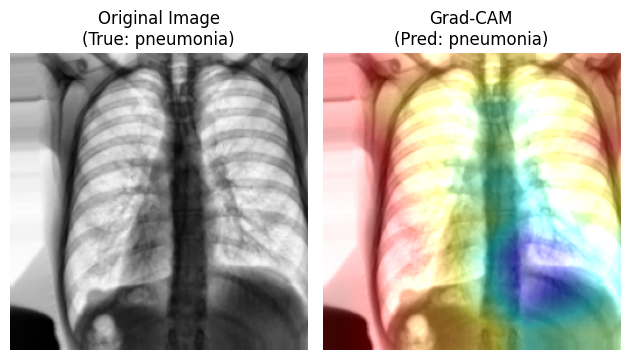


Processing image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_165.png
Sample image shape: (256, 256, 3)
Sample image min/max: 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: covid19
Predictions: [9.8655266e-01 9.8568748e-16 1.3447320e-02]
Heatmap shape: (8, 8)
Heatmap min/max: 0.0 1.0
Plot saved to: /kaggle/working/grad_cam_normal.png


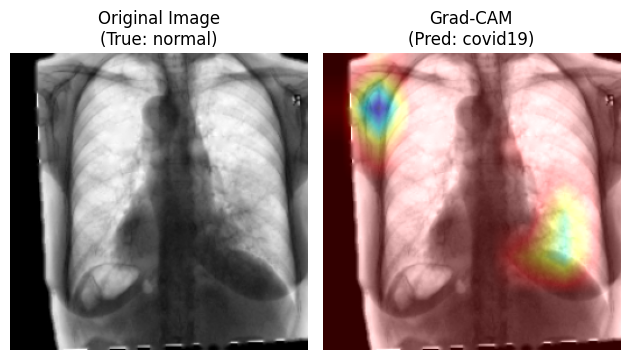

In [26]:
for img_path, class_label in image_paths:
    apply_grad_cam(
        model=model,
        image_path=img_path,
        class_label=class_label,
        class_labels=class_labels,
        last_conv_layer_name='block14_sepconv2_act',
        save_dir='.'
    )

### DEEPLIFT

In [27]:
class_labels = ['covid19', 'normal', 'pneumonia']
label_to_index = {label: idx for idx, label in enumerate(class_labels)}

images = []
labels = []

for path, label_str in image_paths:
    img_normalized, _ = preprocess_image(path)  
    if img_normalized is not None:
        images.append(img_normalized)
        labels.append(label_to_index[label_str])

sample_images = np.array(images)
sample_labels = np.array(labels)


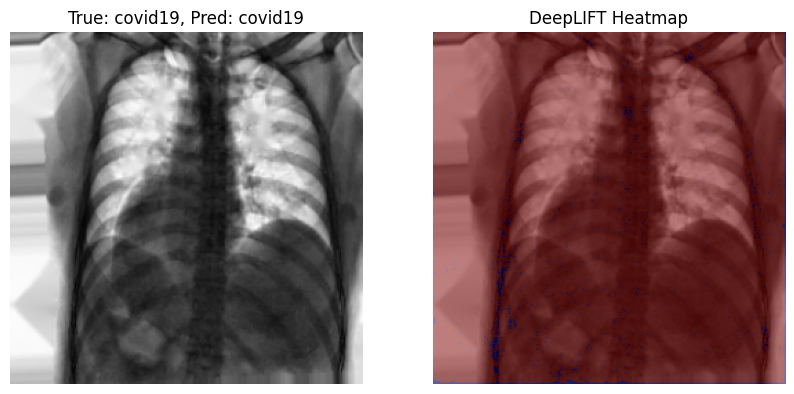

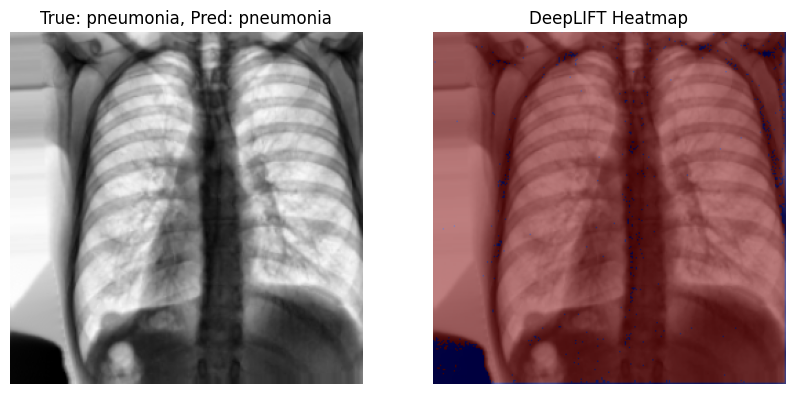

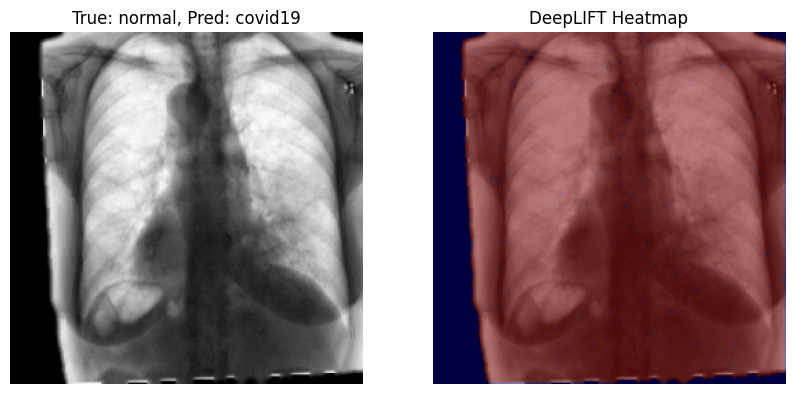

In [28]:
for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    heatmap, pred_class = deeplift(model, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {class_labels[labels[i]]}, Pred: {class_labels[pred_class]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()

### permutation Importance

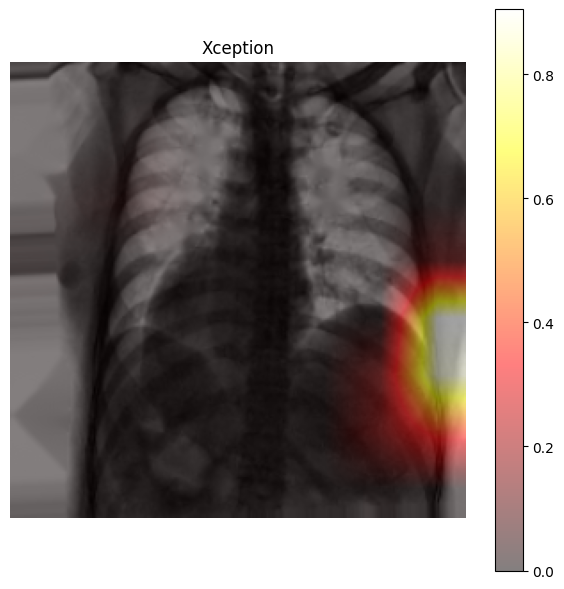

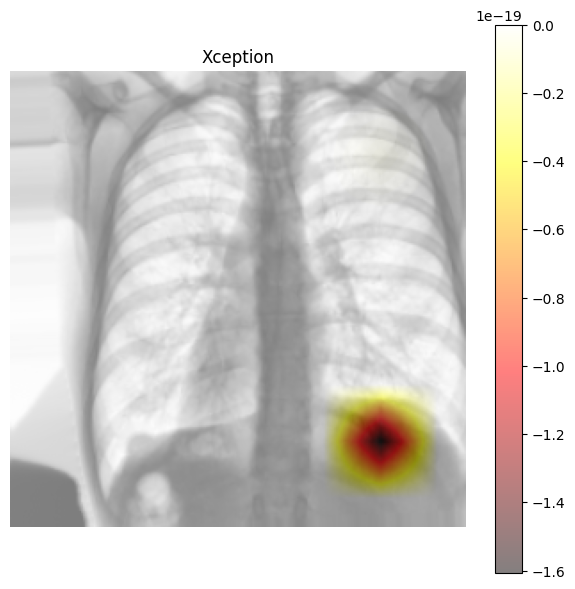

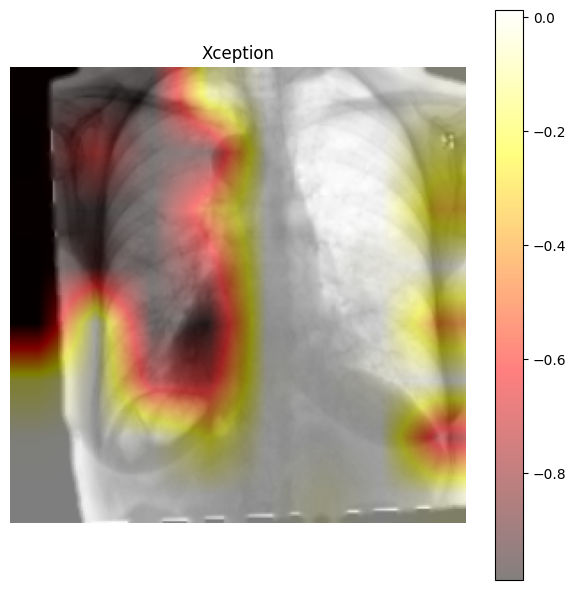

In [29]:
img_covid = sample_images[0]
img_pneumnia = sample_images[1]
img_normal = sample_images[2]


permutation_importance(img_covid, model, class_index=0, model_name="Xception", raw_image=img_covid)
permutation_importance(img_pneumnia, model, class_index=1, model_name="Xception", raw_image=img_pneumnia)
permutation_importance(img_normal, model, class_index=2, model_name="Xception", raw_image=img_normal)